In [1]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.de import German
import pycrfsuite
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import random
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt

In [12]:
def chunker_list(seq, size):
    return list((seq[i::size] for i in range(size)))
# https://stackoverflow.com/questions/24483182/python-split-list-into-n-chunks

In [4]:
def cross_validation(k, language, dataform, datadir):
    if language != 'eng' and language != 'deu': raise ValueError('Language parameter incorrect.')
    if language == 'eng': nlp = English()
    if language == 'deu': nlp = German()
    tokenizer = Tokenizer(nlp.vocab)
    data = read_text_labeled_sentences(datadir, language, dataform, tokenizer)
    print("Cross validation of " + str(len(data)) + " sample sentences has begun")
    random.shuffle(data)
    main(k, dataform, data)

In [5]:
def read_text_labeled_sentences(datadir, language, dataform, tokenizer):
    with open(datadir) as f:
        lines = f.readlines() # list containing lines of file
    sentence = ""
    labels = []
    TRAINING_DATA = []
    for line in lines:
        if line.startswith('-DOCSTART-') or line.startswith('#'): continue
        elif line == '\n':
            if labels == [] and sentence == "": continue
            tokens = tokenizer(sentence.lstrip())
            TRAINING_DATA.append((tokens,labels))
            sentence = ""
            labels = []          
        else:
            if dataform == 'conll' and language == 'eng':
                elements = line.split(' ')
                word = elements[0]
                label = elements[3][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'sec' and language == 'eng':
                elements = line.split(' ')
                word = elements[0]
                label = elements[3][:-1]
                labels.append(label)
                sentence += word + ' ' # same as conll but this one is for the final model filename
            elif dataform == 'conllger' and language == 'deu':
                elements = line.split(' ')
                word = elements[0]
                label = elements[4][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'wnut' and language == 'eng':
                elements = line.split('\t')
                word = elements[0]
                label = elements[1][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'legal' and language == 'deu':
                elements = line.split(' ')
                word = elements[0]
                label = elements[1][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'conllsec' and language == 'eng':
                elements = line.split(' ')
                word = elements[0]
                label = elements[1][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'germeval' and language == 'deu':
                elements = line.split('\t')
                word = elements[1]
                label = elements[2]
                labels.append(label)
                sentence += word + ' '
            else: raise ValueError('dataform or language parameter incorrect.')
    return TRAINING_DATA

def main(k, dataform, data):
    cvset = chunker_list(data, k)
    acculs, prmls, prwls, remls, rewls, fmls, fwls = [], [], [], [], [], [], []
    for i in range(k):
        print("Cross validation iteration No. " + str(i+1))
        # Divide dataset into train and test sets
        training_data = cvset[:i] + cvset[i+1:]
        training_data = sum(training_data, [])
        test_data = cvset[i]    
        
        # Calculate features for both training and test datasets
        X_train = [sent2features(s[0]) for s in training_data]
        y_train = [s[1] for s in training_data]
        X_test = [sent2features(s[0]) for s in test_data]
        y_test = [s[1] for s in test_data]
        # Train the model
        
        model_path = '../../models/' + dataform + str(i+1)
        train(X_train, y_train, model_path)
        print("The training is finished")
        
        # Predict labels for a given sentence example
        tagger = pycrfsuite.Tagger()
        tagger.open(model_path)
        print("The prediction is finished")

        print("Example sentence: {}".format(test_data[0][0]))
        print("predicted labels: {}". format(tagger.tag(X_test[0])))
        print("real labels {}".format(y_test[0]))

        # Calculate test metrics
        outputs = []
        for i in range(len(X_test)):
            outputs.append(tagger.tag(X_test[i]))

        targets = sum(y_test, [])
        outputs = sum(outputs, [])
        
        print("The calculated metrics:")
        print("conf_matrix: \n", confusion_matrix(targets, outputs))
        accu = accuracy_score(targets, outputs)
        print("accuracy: ", accu)
        acculs.append(accu)
        prm = precision_score(targets, outputs, average='macro')
        print("precision macro: ", prm)
        prmls.append(prm)
        prw = precision_score(targets, outputs, average='weighted')
        print("precision weighted: ", prw)
        prwls.append(prwls)
        rem = recall_score(targets, outputs, average='macro')
        print("recall macro: ", rem)
        remls.append(rem)
        rew = recall_score(targets, outputs, average='weighted')
        print("recall weighted: ", rew)
        rewls.append(rew)
        fm = f1_score(targets, outputs, average='macro')
        print("F1 macro: ", fm)
        fmls.append(fm)
        fw = f1_score(targets, outputs, average='weighted')
        print("F1 weighted: ", fw)
        fwls.append(fw)
    print("Cross validation complete.")
    try: 
        accumean = sum(acculs)/len(acculs)
        print("Accuracy mean: ", accumean)
    except:
        print("Something wrong with accuracy mean. Moving on.")
        pass
    try:
        prmmean = sum(prmls)/len(prmls)
        print("Precision macro mean: ", prmmean)
    except:
        print("Something wrong with precision macro mean. Moving on.")
        pass
    try:
        prwmean = sum(prwls)/len(prwls)
        print("Precision weighted mean: ", prwmean)
    except:
        print("Something wrong with precision weighted mean. Moving on.")
        pass
    try:
        remmean = sum(remls)/len(remls)
        print("Recall macro mean: ", remmean)
    except:
        print("Something wrong with recall macro mean. Moving on.")
        pass
    try:
        rewmean = sum(rewls)/len(rewls)
        print("Recall weighted mean: ", rewmean)
    except:
        print("Something wrong with recall weighted mean. Moving on.")
        pass
    try:
        fmmean = sum(fmls)/len(fmls)
        print("F1 macro mean: ", fmmean)
    except:
        print("Something wrong with F1 macro mean. Moving on.")
        pass
    try:
        fwmean = sum(fwls)/len(fwls)
        print("F1 weighted mean: ", fwmean)
    except:
        print("Something wrong with F1 weighted mean. Moving on.")
        pass
        print("Printing complete.")

def word2features(train_sample, i):
    token = train_sample[i]
    word = token.text
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'word.pos='+token.pos_,
        'word.dep='+token.dep_,
        'word.is_stop=%s' %token.is_stop,
        'word.lemma=' + token.lemma_,
        'word.tag=' + token.tag_,
        'word.shape=' + token.shape_,
        'word.is_alpha=%s' %token.is_alpha,        
    ]
    if i > 0:
        token1 = train_sample[i-1]
        word1 = token1.text
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.pos='+token1.pos_,
            '-1:word.dep='+token1.dep_,
            '-1:word.is_stop=%s' %token1.is_stop,
            '-1:word.lemma=' + token1.lemma_,
            '-1:word.tag=' + token1.tag_,
            '-1:word.shape=' + token1.shape_,
            '-1:word.is_alpha=%s' %token1.is_alpha,    
        ])
    else:
        features.append('BOS')
        
    if i < len(train_sample)-1:
        token1 = train_sample[i+1]
        word1 = token1.text
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.pos='+token1.pos_,
            '+1:word.dep='+token1.dep_,
            '+1:word.is_stop=%s' %token1.is_stop,
            '+1:word.lemma=' + token1.lemma_,
            '+1:word.tag=' + token1.tag_,
            '+1:word.shape=' + token1.shape_,
            '+1:word.is_alpha=%s' %token1.is_alpha,   
        ])
    else:
        features.append('EOS')       
    return features

def sent2features(train_sample):
    return [word2features(train_sample, i) for i in range(len(train_sample))]

def train(X_train, y_train, model_path):
    trainer = pycrfsuite.Trainer(verbose=False)

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.set_params({
        'c1': 0.44,   # coefficient for L1 penalty
        'c2': 1e-4,  # coefficient for L2 penalty
        'max_iterations': 60,  # stop earlier

        # include transitions that are possible, but not observed
        'feature.possible_transitions': True
    })
    print("model's parameters : {}".format(trainer.params()))
    trainer.train(model_path)
    print("Last iteration log {}".format(trainer.logparser.last_iteration))

In [5]:
# print('10-fold, Conll2003, German, CRF')
# %time cross_validation(10, 'deu',  'conllger' , '../../data/conll2003/deu.all')

In [6]:
# print('10-fold, LegalER, German, CRF')
# %time cross_validation(10, 'deu',  'legal' , '../../data/LegalER/dataset_courts/deu.all')

In [7]:
# print('10-fold, GermEval2014, German, CRF')
# %time cross_validation(10, 'deu',  'germeval' , '../../data/GermEval2014/deu.all.tsv')

In [8]:
# print('10-fold, Conll2003, English, CRF')
# %time cross_validation(10, 'eng',  'conll' , '../../data/conll2003/eng.all')

In [9]:
# print('10-fold, SEC-filings, English, CRF')
# %time cross_validation(10, 'eng',  'sec' , '../../data/SEC-filings/CONLL-format/data/eng.all')

In [10]:
# print('8-fold, SEC-filings, English, CRF')
# %time cross_validation(8, 'eng',  'sec' , '../../data/SEC-filings/CONLL-format/data/eng.all')

In [11]:
# print('10-fold, WNUT17, English, CRF')
# %time cross_validation(10, 'eng',  'wnut' , '../../data/WNUT17/CONLL-format/data/engnopos.all')

In [1]:
# print('10-fold, conllger + GermEval, German, CRF')
# %time cross_validation(10, 'deu',  'legal' , '../../data/conllgermeval.all')

10-fold, conllger + GermEval, German, CRF


NameError: name 'cross_validation' is not defined

In [ ]:
# print('10-fold, conlleng + sec, English, CRF')
# %time cross_validation(10, 'eng',  'conllsec' , '../../data/eng.conllsec')

10-fold, conlleng + sec, English, CRF
Cross validation of 22211 sample sentences has begun
Cross validation iteration No. 1


IOStream.flush timed out


The training is finished
The prediction is finished
The calculated metrics:
conf_matrix: 
 [[4406    0    0    3    0    0    0    0    0    0    0    0    3   14
     0    0    0    0    0    0    0    1    0    0    0    2    0    0
     0    0    0]
 [   0    8    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    4    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   2    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [  26    0    0 3938    2    0    0    0    6    0    8    0    5   20
     0    0    0    0    0    3    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    1 2548    0    0    4    0    0    0    0    1    2
     0    1    0    0    0    0    0    0    0    0    1    0    0    2
     0    0    0]
 [   0    0    0    0    0   19    0    0    0    0    0    0    0    0
     0    0    0    0    0 

/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision macro:  0.8663826760934515
precision weighted:  0.9587131247194556
recall macro:  0.813784986545404
recall weighted:  0.9592152668317946
F1 macro:  0.8312324418512149
F1 weighted:  0.9586903498181899
Cross validation iteration No. 2
The training is finished
The prediction is finished
The calculated metrics:
conf_matrix: 
 [[4270    0    0    2    0    0    0    0    2    0    0    0    3    5
     0    0    0    0    0    0    0    1    0    0    0    1    0    0
     0    0    0]
 [   0    3    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    8    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   7    0    0 3932    0    0    0    1   11    1    0    0    1   10
     0    0    0    0    0    0    0    0    0    0    1    0    0    0
     0    0    0]
 [   0    0    0  

/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision weighted:  0.9591169353220828
recall macro:  0.792180147132668
recall weighted:  0.9597034353953251
F1 macro:  0.8193149736267517
F1 weighted:  0.9589908665896044
Cross validation iteration No. 3
The training is finished
The prediction is finished
The calculated metrics:
conf_matrix: 
 [[4323    0    0    0    0    0    0    0    1    0    0    0    2    5
     0    0    0    0    0    0    0    0    0    0    0    0    2    0
     0    0    0]
 [   0    7    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    1    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [  10    0    0 3968    0    0    0    1   11    0    0    0    1   19
     0    0    0    0    0    0    1    0    0    0    0    0    1    0
     0    0    0]
 [   0    0    0    0 2464    0    0    5    1    0    

/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision macro:  0.8799424889454458
precision weighted:  0.9606229162268629
recall macro:  0.8317756526087379
recall weighted:  0.9612451627589347
F1 macro:  0.8478015229350696
F1 weighted:  0.960632410193219
Cross validation iteration No. 4
The training is finished
The prediction is finished
The calculated metrics:
conf_matrix: 
 [[4285    0    0 ...    0    0    0]
 [   0    4    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    3    0    0]
 [   0    0    0 ...    0   54    0]
 [   0    0    0 ...    0    0    0]]
accuracy:  0.9591819416157502


/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision macro:  0.848451681987821
precision weighted:  0.958757546704541


/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wangt/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall macro:  0.7832295741347224
recall weighted:  0.9591819416157502
F1 macro:  0.8035436521370448
F1 weighted:  0.9586477752096018
Cross validation iteration No. 5


In [ ]:
# %time cross_validation(10, 'deu',  'legal' , '../../data/LegalER/dataset_courts/bag.conll', None)

In [ ]:
# list(chunker_list([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], 3))

In [ ]:
# filepath = '../../data/conll2003/eng.all'
# filepath.rsplit('/', 1)[1]

In [15]:
def finaltrain_joint(tokenizer):
    with open('../../data/conllgermeval.all') as f:
        trainlines = f.readlines() # list containing lines of file
    with open('../../data/conll2003/deu_utf.testb') as tf:
        testlines = tf.readlines()
    sentence = ""
    labels = []
    TRAINING_DATA = []
    TEST_DATA = []
    
    for line in trainlines:
        if line.startswith('-DOCSTART-') or line.startswith('#'): continue
        elif line == '\n':
            if labels == [] and sentence == "": continue
            tokens = tokenizer(sentence.lstrip())
            TRAINING_DATA.append((tokens,labels))
            sentence = ""
            labels = []          
        else:
            elements = line.split(' ')
            label = elements[1][:-1]
            if label.endswith('PE'): label += 'R'
            if label.endswith('LO'): label += 'C'
            if label.endswith('MIS'): label += 'C'
            if label.endswith('OR'): label += 'G'
            word = elements[0]
            labels.append(label)
            sentence += word + ' '

        # Calculate features for both training and test datasets
    X_train = [sent2features(s[0]) for s in TRAINING_DATA]
    y_train = [s[1] for s in TRAINING_DATA]

        # Train the model
        
    model_path = '../../models/finaljoint'
    train(X_train, y_train, model_path)
    print("The training is finished, model saved")
    
    for line in testlines:
        if line.startswith('-DOCSTART-') or line.startswith('#'): continue
        elif line == '\n':
            if labels == [] and sentence == "": continue
            tokens = tokenizer(sentence.lstrip())
            TEST_DATA.append((tokens,labels))
            sentence = ""
            labels = []          
        else:
            elements = line.split(' ')
            word = elements[0]
            label = elements[-1][:-1]
            if label.endswith('PE'): label += 'R'
            if label.endswith('LO'): label += 'C'
            if label.endswith('MIS'): label += 'C'
            if label.endswith('OR'): label += 'G'
            labels.append(label)
            sentence += word + ' '

    X_test = [sent2features(s[0]) for s in TEST_DATA]
    y_test = [s[1] for s in TEST_DATA]
            
    tagger = pycrfsuite.Tagger()
    tagger.open(model_path)
    print("The prediction is finished")

    print("Example sentence: {}".format(TEST_DATA[0][0]))
    print("predicted labels: {}". format(tagger.tag(X_test[0])))
    print("real labels {}".format(y_test[0]))

        # Calculate test metrics
    outputs = []
    for i in range(len(X_test)):
        outputs.append(tagger.tag(X_test[i]))

    targets = sum(y_test, [])
    outputs = sum(outputs, [])
        
        
    cm = confusion_matrix(targets, outputs, labels = ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC'])
    print("conf_matrix: \n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("Printing complete.")


def word2features(train_sample, i):
    token = train_sample[i]
    word = token.text
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'word.pos='+token.pos_,
        'word.dep='+token.dep_,
        'word.is_stop=%s' %token.is_stop,
        'word.lemma=' + token.lemma_,
        'word.tag=' + token.tag_,
        'word.shape=' + token.shape_,
        'word.is_alpha=%s' %token.is_alpha,        
    ]
    if i > 0:
        token1 = train_sample[i-1]
        word1 = token1.text
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.pos='+token1.pos_,
            '-1:word.dep='+token1.dep_,
            '-1:word.is_stop=%s' %token1.is_stop,
            '-1:word.lemma=' + token1.lemma_,
            '-1:word.tag=' + token1.tag_,
            '-1:word.shape=' + token1.shape_,
            '-1:word.is_alpha=%s' %token1.is_alpha,    
        ])
    else:
        features.append('BOS')
        
    if i < len(train_sample)-1:
        token1 = train_sample[i+1]
        word1 = token1.text
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.pos='+token1.pos_,
            '+1:word.dep='+token1.dep_,
            '+1:word.is_stop=%s' %token1.is_stop,
            '+1:word.lemma=' + token1.lemma_,
            '+1:word.tag=' + token1.tag_,
            '+1:word.shape=' + token1.shape_,
            '+1:word.is_alpha=%s' %token1.is_alpha,   
        ])
    else:
        features.append('EOS')       
    return features

def sent2features(train_sample):
    return [word2features(train_sample, i) for i in range(len(train_sample))]

def train(X_train, y_train, model_path):
    trainer = pycrfsuite.Trainer(verbose=False)

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.set_params({
        'c1': 0.44,   # coefficient for L1 penalty
        'c2': 1e-4,  # coefficient for L2 penalty
        'max_iterations': 60,  # stop earlier

        # include transitions that are possible, but not observed
        'feature.possible_transitions': True
    })
    print("model's parameters : {}".format(trainer.params()))
    trainer.train(model_path)
    print("Last iteration log {}".format(trainer.logparser.last_iteration))
#['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC']
# tp = 2+392+746+12+25+1+19+20+174+471
# fn = 10+27+4+6+1+21+39+11+13
# fp = 24+41+21+41+1+1+14+15+3+19

In [17]:
tp = 2+392+746+12+25+1+19+20+174+471
fn = 10+27+4+6+1+21+39+11+13
fp = 24+41+21+41+1+1+14+15+3+19
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision ', precision)
print('Recall ', recall)
print('F1 ', f1)

Precision  0.9118511263467189
Recall  0.9338014042126379
F1  0.9226957383548069


model's parameters : ['feature.minfreq', 'feature.possible_states', 'feature.possible_transitions', 'c1', 'c2', 'max_iterations', 'num_memories', 'epsilon', 'period', 'delta', 'linesearch', 'max_linesearch']
Last iteration log {'num': 60, 'scores': {}, 'loss': 182875.761112, 'feature_norm': 71.517578, 'error_norm': 346064.869202, 'active_features': 329823, 'linesearch_trials': 1, 'linesearch_step': 1.0, 'time': 1.669}
The training is finished, model saved
The prediction is finished
Example sentence: Presseberichten zufolge war es ihm zuvor auch gelungen , das Köpenicker Postamt für Telefonate nach Berlin eine Stunde lang sperren zu lassen . 
predicted labels: ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'B-LOC', '', '', '', '', '', '', '']
real labels ['', '', '', '', '', '', '', '', '', '', 'B-MISC', '', '', '', '', 'B-LOC', '', '', '', '', '', '', '']
conf_matrix: 
 [[  0   2   0   0   0   0   0   0]
 [392 746  12  25  10  27   4   6]
 [  0   0   1   0   0   1   0   0

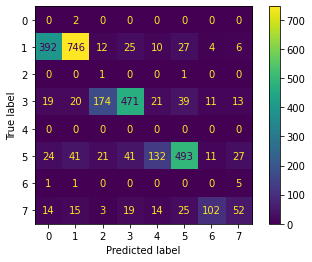

Printing complete.


In [16]:
nlp = German()
tokenizer = Tokenizer(nlp.vocab)
finaltrain_joint(tokenizer)

In [20]:

def finaltrain_conll(tokenizer):
    with open('../../data/conll2003/deu.all') as f:
        trainlines = f.readlines() # list containing lines of file
    with open('../../data/conll2003/deu_utf.testb') as tf:
        testlines = tf.readlines()
    sentence = ""
    labels = []
    TRAINING_DATA = []
    TEST_DATA = []
    
    for line in trainlines:
        if line.startswith('-DOCSTART-') or line.startswith('#'): continue
        elif line == '\n':
            if labels == [] and sentence == "": continue
            tokens = tokenizer(sentence.lstrip())
            TRAINING_DATA.append((tokens,labels))
            sentence = ""
            labels = []          
        else:
            elements = line.split(' ')
            label = elements[-1][:-1]
            if label.endswith('PE'): label += 'R'
            if label.endswith('LO'): label += 'C'
            if label.endswith('MIS'): label += 'C'
            if label.endswith('OR'): label += 'G'
            word = elements[0]
            labels.append(label)
            sentence += word + ' '

        # Calculate features for both training and test datasets
    X_train = [sent2features(s[0]) for s in TRAINING_DATA]
    y_train = [s[1] for s in TRAINING_DATA]

        # Train the model
        
    model_path = '../../models/finalconllanon'
    train(X_train, y_train, model_path)
    print("The training is finished, model saved")
    
    for line in testlines:
        if line.startswith('-DOCSTART-') or line.startswith('#'): continue
        elif line == '\n':
            if labels == [] and sentence == "": continue
            tokens = tokenizer(sentence.lstrip())
            TEST_DATA.append((tokens,labels))
            sentence = ""
            labels = []          
        else:
            elements = line.split(' ')
            word = elements[0]
            label = elements[-1][:-1]
            if label.endswith('PE'): label += 'R'
            if label.endswith('LO'): label += 'C'
            if label.endswith('MIS'): label += 'C'
            if label.endswith('OR'): label += 'G'
            labels.append(label)
            sentence += word + ' '

    X_test = [sent2features(s[0]) for s in TEST_DATA]
    y_test = [s[1] for s in TEST_DATA]
            
    tagger = pycrfsuite.Tagger()
    tagger.open(model_path)
    print("The prediction is finished")

    print("Example sentence: {}".format(TEST_DATA[0][0]))
    print("predicted labels: {}". format(tagger.tag(X_test[0])))
    print("real labels {}".format(y_test[0]))

        # Calculate test metrics
    outputs = []
    for i in range(len(X_test)):
        outputs.append(tagger.tag(X_test[i]))

    targets = sum(y_test, [])
    outputs = sum(outputs, [])
        
        
    cm = confusion_matrix(targets, outputs, labels = ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC'])
    print("conf_matrix: \n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("Printing complete.")


def word2features(train_sample, i):
    token = train_sample[i]
    word = token.text
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'word.pos='+token.pos_,
        'word.dep='+token.dep_,
        'word.is_stop=%s' %token.is_stop,
        'word.lemma=' + token.lemma_,
        'word.tag=' + token.tag_,
        'word.shape=' + token.shape_,
        'word.is_alpha=%s' %token.is_alpha,        
    ]
    if i > 0:
        token1 = train_sample[i-1]
        word1 = token1.text
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.pos='+token1.pos_,
            '-1:word.dep='+token1.dep_,
            '-1:word.is_stop=%s' %token1.is_stop,
            '-1:word.lemma=' + token1.lemma_,
            '-1:word.tag=' + token1.tag_,
            '-1:word.shape=' + token1.shape_,
            '-1:word.is_alpha=%s' %token1.is_alpha,    
        ])
    else:
        features.append('BOS')
        
    if i < len(train_sample)-1:
        token1 = train_sample[i+1]
        word1 = token1.text
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.pos='+token1.pos_,
            '+1:word.dep='+token1.dep_,
            '+1:word.is_stop=%s' %token1.is_stop,
            '+1:word.lemma=' + token1.lemma_,
            '+1:word.tag=' + token1.tag_,
            '+1:word.shape=' + token1.shape_,
            '+1:word.is_alpha=%s' %token1.is_alpha,   
        ])
    else:
        features.append('EOS')       
    return features

def sent2features(train_sample):
    return [word2features(train_sample, i) for i in range(len(train_sample))]

def train(X_train, y_train, model_path):
    trainer = pycrfsuite.Trainer(verbose=False)

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.set_params({
        'c1': 0.44,   # coefficient for L1 penalty
        'c2': 1e-4,  # coefficient for L2 penalty
        'max_iterations': 60,  # stop earlier

        # include transitions that are possible, but not observed
        'feature.possible_transitions': True
    })
    print("model's parameters : {}".format(trainer.params()))
    trainer.train(model_path)
    print("Last iteration log {}".format(trainer.logparser.last_iteration))
#['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-LOC', 'B-MISC', 'I-MISC']



In [22]:
tp = 2+1329+35+13+827
fn = 43+3+1+44+25
fp = 26+78+6+17

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) / (precision + recall)
print('Precision ', precision)
print('Recall ', recall)
print('F1 ', f1)

Precision  0.9455636519502786
Recall  0.9500430663221361
F1  0.947798066595059


model's parameters : ['feature.minfreq', 'feature.possible_states', 'feature.possible_transitions', 'c1', 'c2', 'max_iterations', 'num_memories', 'epsilon', 'period', 'delta', 'linesearch', 'max_linesearch']
Last iteration log {'num': 60, 'scores': {}, 'loss': 17170.435663, 'feature_norm': 242.095638, 'error_norm': 346.991289, 'active_features': 22948, 'linesearch_trials': 1, 'linesearch_step': 1.0, 'time': 0.424}
The training is finished, model saved
The prediction is finished
Example sentence: Die heilige Messe könne daher , auch außerhalb der Kirche , mehr auf Jugendinteressen abgestimmt werden , heißt es im neuen " Pfarrboten " der beiden katholischen Kirchengemeinden von Mörfelden-Walldorf . 
predicted labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-LOC', 'O']
real labels ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

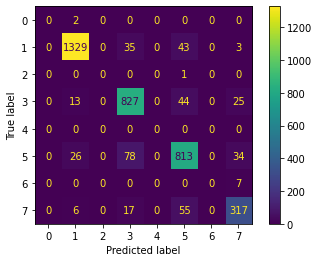

Printing complete.


In [21]:
nlp = German()
tokenizer = Tokenizer(nlp.vocab)
finaltrain_conll(tokenizer)

In [1]:
def read_text_labeled_sentences(datadir, language, dataform, tokenizer):
    with open(datadir) as f:
        lines = f.readlines() # list containing lines of file
    sentence = ""
    labels = []
    TRAINING_DATA = []
    for line in lines:
        if line.startswith('-DOCSTART-') or line.startswith('#'): continue
        elif line == '\n':
            if labels == [] and sentence == "": continue
            tokens = tokenizer(sentence.lstrip())
            TRAINING_DATA.append((tokens,labels))
            sentence = ""
            labels = []          
        else:
            if dataform == 'conll' and language == 'eng':
                elements = line.split(' ')
                word = elements[0]
                label = elements[3][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'sec' and language == 'eng':
                elements = line.split(' ')
                word = elements[0]
                label = elements[3][:-1]
                labels.append(label)
                sentence += word + ' ' # same as conll but for model filename
            elif dataform == 'conllger' and language == 'deu':
                elements = line.split(' ')
                word = elements[0]
                label = elements[4][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'wnut' and language == 'eng':
                elements = line.split('\t')
                word = elements[0]
                label = elements[1][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'legal' and language == 'deu':
                elements = line.split(' ')
                word = elements[0]
                label = elements[1][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'conllsec' and language == 'eng':
                elements = line.split(' ')
                word = elements[0]
                label = elements[1][:-1]
                labels.append(label)
                sentence += word + ' '
            elif dataform == 'germeval' and language == 'deu':
                elements = line.split('\t')
                word = elements[1]
                label = elements[2]
                labels.append(label)
                sentence += word + ' '
            else: raise ValueError('dataform or language parameter incorrect.')
    return TRAINING_DATA

def main(k, dataform, data):
    cvset = chunker_list(data, k)
    acculs, prmls, prwls, remls, rewls, fmls, fwls = [], [], [], [], [], [], []
    for i in range(k):
        print("Cross validation iteration No. " + str(i+1))
        # Divide dataset into train and test sets
        training_data = cvset[:i] + cvset[i+1:]
        training_data = sum(training_data, [])
        test_data = cvset[i]    
        
        # Calculate features for both training and test datasets
        X_train = [sent2features(s[0]) for s in training_data]
        y_train = [s[1] for s in training_data]
        X_test = [sent2features(s[0]) for s in test_data]
        y_test = [s[1] for s in test_data]
        # Train the model
        
        model_path = '../../models/' + dataform + str(i+1)
        train(X_train, y_train, model_path)
        print("The training is finished")
        
        # Predict labels for a given sentence example
        tagger = pycrfsuite.Tagger()
        tagger.open(model_path)
        print("The prediction is finished")

        print("Example sentence: {}".format(test_data[0][0]))
        print("predicted labels: {}". format(tagger.tag(X_test[0])))
        print("real labels {}".format(y_test[0]))

        # Calculate test metrics
        outputs = []
        for i in range(len(X_test)):
            outputs.append(tagger.tag(X_test[i]))

        targets = sum(y_test, [])
        outputs = sum(outputs, [])
        
        print("The calculated metrics:")
        print("conf_matrix: \n", confusion_matrix(targets, outputs))
        accu = accuracy_score(targets, outputs)
        print("accuracy: ", accu)
        acculs.append(accu)
        prm = precision_score(targets, outputs, average='macro')
        print("precision macro: ", prm)
        prmls.append(prm)
        prw = precision_score(targets, outputs, average='weighted')
        print("precision weighted: ", prw)
        prwls.append(prwls)
        rem = recall_score(targets, outputs, average='macro')
        print("recall macro: ", rem)
        remls.append(rem)
        rew = recall_score(targets, outputs, average='weighted')
        print("recall weighted: ", rew)
        rewls.append(rew)
        fm = f1_score(targets, outputs, average='macro')
        print("F1 macro: ", fm)
        fmls.append(fm)
        fw = f1_score(targets, outputs, average='weighted')
        print("F1 weighted: ", fw)
        fwls.append(fw)
    print("Cross validation complete.")
    try: 
        accumean = sum(acculs)/len(acculs)
        print("Accuracy mean: ", accumean)
    except:
        print("Something wrong with accuracy mean. Moving on.")
        pass
    try:
        prmmean = sum(prmls)/len(prmls)
        print("Precision macro mean: ", prmmean)
    except:
        print("Something wrong with precision macro mean. Moving on.")
        pass
    try:
        prwmean = sum(prwls)/len(prwls)
        print("Precision weighted mean: ", prwmean)
    except:
        print("Something wrong with precision weighted mean. Moving on.")
        pass
    try:
        remmean = sum(remls)/len(remls)
        print("Recall macro mean: ", remmean)
    except:
        print("Something wrong with recall macro mean. Moving on.")
        pass
    try:
        rewmean = sum(rewls)/len(rewls)
        print("Recall weighted mean: ", rewmean)
    except:
        print("Something wrong with recall weighted mean. Moving on.")
        pass
    try:
        fmmean = sum(fmls)/len(fmls)
        print("F1 macro mean: ", fmmean)
    except:
        print("Something wrong with F1 macro mean. Moving on.")
        pass
    try:
        fwmean = sum(fwls)/len(fwls)
        print("F1 weighted mean: ", fwmean)
    except:
        print("Something wrong with F1 weighted mean. Moving on.")
        pass
        print("Printing complete.")

def word2features(train_sample, i):
    token = train_sample[i]
    word = token.text
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'word.pos='+token.pos_,
        'word.dep='+token.dep_,
        'word.is_stop=%s' %token.is_stop,
        'word.lemma=' + token.lemma_,
        'word.tag=' + token.tag_,
        'word.shape=' + token.shape_,
        'word.is_alpha=%s' %token.is_alpha,        
    ]
    if i > 0:
        token1 = train_sample[i-1]
        word1 = token1.text
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.pos='+token1.pos_,
            '-1:word.dep='+token1.dep_,
            '-1:word.is_stop=%s' %token1.is_stop,
            '-1:word.lemma=' + token1.lemma_,
            '-1:word.tag=' + token1.tag_,
            '-1:word.shape=' + token1.shape_,
            '-1:word.is_alpha=%s' %token1.is_alpha,    
        ])
    else:
        features.append('BOS')
        
    if i < len(train_sample)-1:
        token1 = train_sample[i+1]
        word1 = token1.text
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.pos='+token1.pos_,
            '+1:word.dep='+token1.dep_,
            '+1:word.is_stop=%s' %token1.is_stop,
            '+1:word.lemma=' + token1.lemma_,
            '+1:word.tag=' + token1.tag_,
            '+1:word.shape=' + token1.shape_,
            '+1:word.is_alpha=%s' %token1.is_alpha,   
        ])
    else:
        features.append('EOS')       
    return features

def sent2features(train_sample):
    return [word2features(train_sample, i) for i in range(len(train_sample))]

def train(X_train, y_train, model_path):
    trainer = pycrfsuite.Trainer(verbose=False)

    for xseq, yseq in zip(X_train, y_train):
        trainer.append(xseq, yseq)

    trainer.set_params({
        'c1': 0.44,   # coefficient for L1 penalty
        'c2': 1e-4,  # coefficient for L2 penalty
        'max_iterations': 60,  # stop earlier

        # include transitions that are possible, but not observed
        'feature.possible_transitions': True
    })
    print("model's parameters : {}".format(trainer.params()))
    trainer.train(model_path)
    print("Last iteration log {}".format(trainer.logparser.last_iteration))

4


In [ ]:
# def finaltrain_conll(tokenizer):
#     with open('../../data/conll2003/deu.all') as f:
#         lines = f.readlines() # list containing lines of file
#     sentence = ""
#     labels = []
#     TRAINING_DATA = []
#     for line in lines:
#         if line.startswith('-DOCSTART-') or line.startswith('#'): continue
#         elif line == '\n':
#             if labels == [] and sentence == "": continue
#             tokens = tokenizer(sentence.lstrip())
#             TRAINING_DATA.append((tokens,labels))
#             sentence = ""
#             labels = []          
#         else:
#             elements = line.split(' ')
#             word = elements[0]
#             label = elements[4][:-1]
#             labels.append(label)
#             sentence += word + ' '
#         # Calculate features for both training and test datasets
#     X_train = [sent2features(s[0]) for s in TRAINING_DATA]
#     y_train = [s[1] for s in TRAINING_DATA]
#         # Train the model
        
#     model_path = '../../models/finalconll'
#     train(X_train, y_train, model_path)
#     print("The training is finished, model saved")

# def word2features(train_sample, i):
#     token = train_sample[i]
#     word = token.text
#     features = [
#         'bias',
#         'word.lower=' + word.lower(),
#         'word[-3:]=' + word[-3:],
#         'word[-2:]=' + word[-2:],
#         'word.isupper=%s' % word.isupper(),
#         'word.istitle=%s' % word.istitle(),
#         'word.isdigit=%s' % word.isdigit(),
#         'word.pos='+token.pos_,
#         'word.dep='+token.dep_,
#         'word.is_stop=%s' %token.is_stop,
#         'word.lemma=' + token.lemma_,
#         'word.tag=' + token.tag_,
#         'word.shape=' + token.shape_,
#         'word.is_alpha=%s' %token.is_alpha,        
#     ]
#     if i > 0:
#         token1 = train_sample[i-1]
#         word1 = token1.text
#         features.extend([
#             '-1:word.lower=' + word1.lower(),
#             '-1:word.istitle=%s' % word1.istitle(),
#             '-1:word.isupper=%s' % word1.isupper(),
#             '-1:word.pos='+token1.pos_,
#             '-1:word.dep='+token1.dep_,
#             '-1:word.is_stop=%s' %token1.is_stop,
#             '-1:word.lemma=' + token1.lemma_,
#             '-1:word.tag=' + token1.tag_,
#             '-1:word.shape=' + token1.shape_,
#             '-1:word.is_alpha=%s' %token1.is_alpha,    
#         ])
#     else:
#         features.append('BOS')
        
#     if i < len(train_sample)-1:
#         token1 = train_sample[i+1]
#         word1 = token1.text
#         features.extend([
#             '+1:word.lower=' + word1.lower(),
#             '+1:word.istitle=%s' % word1.istitle(),
#             '+1:word.isupper=%s' % word1.isupper(),
#             '+1:word.pos='+token1.pos_,
#             '+1:word.dep='+token1.dep_,
#             '+1:word.is_stop=%s' %token1.is_stop,
#             '+1:word.lemma=' + token1.lemma_,
#             '+1:word.tag=' + token1.tag_,
#             '+1:word.shape=' + token1.shape_,
#             '+1:word.is_alpha=%s' %token1.is_alpha,   
#         ])
#     else:
#         features.append('EOS')       
#     return features

# def sent2features(train_sample):
#     return [word2features(train_sample, i) for i in range(len(train_sample))]

# def train(X_train, y_train, model_path):
#     trainer = pycrfsuite.Trainer(verbose=False)

#     for xseq, yseq in zip(X_train, y_train):
#         trainer.append(xseq, yseq)

#     trainer.set_params({
#         'c1': 0.44,   # coefficient for L1 penalty
#         'c2': 1e-4,  # coefficient for L2 penalty
#         'max_iterations': 60,  # stop earlier

#         # include transitions that are possible, but not observed
#         'feature.possible_transitions': True
#     })
#     print("model's parameters : {}".format(trainer.params()))
#     trainer.train(model_path)
#     print("Last iteration log {}".format(trainer.logparser.last_iteration))